In [1]:
import numpy as np
import pandas as pd
from global_macro_data import gmd

In [2]:
df_macro = gmd(variables=["rGDP", "CPI", "unemp", "pop", "finv", "cbrate", "exports", "imports", "REER", "M0"])
df_macro = df_macro[(df_macro['year'] >= 1977) & (df_macro['year'] <= 2023)]
print("Number of countries: ", df_macro["ISO3"].nunique())
print("Number of observations: ", df_macro.shape[0])
df_macro

Downloading: https://www.globalmacrodata.com/GMD_2025_03.csv
Selected 13 variables
Final dataset: 56303 observations of 13 variables
Number of countries:  242
Number of observations:  11307


,ISO3,countryname,year,rGDP,CPI,unemp,pop,finv,cbrate,exports,imports,REER,M0
27,ABW,Aruba,1977,750.31738,NaN,NaN,0.058580,1.491748e+02,NaN,4.733627e+02,3.951794e+02,NaN,NaN
28,ABW,Aruba,1978,818.50983,NaN,NaN,0.058776,1.571261e+02,NaN,4.985999e+02,4.162520e+02,NaN,NaN
29,ABW,Aruba,1979,892.89996,NaN,NaN,0.059191,1.655022e+02,NaN,5.251772e+02,4.384366e+02,NaN,NaN
30,ABW,Aruba,1980,974.05096,31.98246,NaN,0.059909,1.743279e+02,NaN,5.531674e+02,4.617983e+02,NaN,NaN
31,ABW,Aruba,1981,1062.57740,NaN,NaN,0.060563,1.836145e+02,NaN,5.826758e+02,4.864549e+02,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56291,ZWE,Zimbabwe,2019,17631.88700,414.68430,7.373,15.271368,2.270128e+04,NaN,5.846286e+04,5.992188e+04,NaN,NaN
56292,ZWE,Zimbabwe,2020,16253.61100,2725.31270,7.373,15.526888,1.385149e+05,NaN,3.073757e+05,3.449788e+05,NaN,NaN
56293,ZWE,Zimbabwe,2021,17629.97100,5411.00240,9.540,15.797210,3.957774e+05,NaN,7.265159e+05,8.954756e+05,NaN,NaN
56294,ZWE,Zimbabwe,2022,18712.32000,11076.60200,10.087,16.069056,1.403235e+06,NaN,3.463218e+06,4.583895e+06,NaN,NaN


In [3]:
country_nan_ratio = df_macro.groupby("ISO3").apply(lambda g: g.isna().mean().mean())
countries_to_drop = country_nan_ratio[country_nan_ratio > 0.1].index.tolist()
df_cleaned = df_macro[~df_macro["ISO3"].isin(countries_to_drop)]
print("Number of countries: ", df_cleaned["ISO3"].nunique())
print("Number of observations: ", df_cleaned.shape[0])
df_cleaned.isna().mean()

Number of countries:  98
Number of observations:  4606


/tmp/ipykernel_181642/2982151676.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  country_nan_ratio = df_macro.groupby("ISO3").apply(lambda g: g.isna().mean().mean())


ISO3           0.000000
countryname    0.000000
year           0.000000
rGDP           0.000000
CPI            0.006079
unemp          0.238602
pop            0.000000
finv           0.000000
cbrate         0.200825
exports        0.004342
imports        0.004342
REER           0.000651
M0             0.139601
dtype: float64

In [4]:
# Sort data for consistent time series filling
df_cleaned = df_cleaned.sort_values(by=["ISO3", "year"])

# Grouped by country for time-aware filling
group = df_cleaned.groupby("ISO3")

# 1. Interpolate numeric time series variables per country
for col in ["unemp", "cbrate", "M0", "exports", "imports", "CPI"]:
    df_cleaned[col] = group[col].transform(lambda g: g.interpolate(method="linear", limit_direction="both"))

# 2. Still missing? Fill remaining NaNs using group mean (per country)
for col in ["unemp", "cbrate", "M0"]:
    df_cleaned[col] = group[col].transform(lambda g: g.fillna(g.mean()))

# Final fill for residual missing values
for col in ["cbrate", "M0"]:
    df_cleaned[col] = df_cleaned.groupby("ISO3")[col].transform(lambda g: g.ffill().bfill())
    
# remove Taiwan and Luxembourg
df_cleaned = df_cleaned[~df_cleaned["ISO3"].isin(["TWN", "LUX"])]
print("Number of countries: ", df_cleaned["ISO3"].nunique())
print("Number of observations: ", df_cleaned.shape[0])
df_cleaned.isna().mean()

Number of countries:  96
Number of observations:  4512


ISO3           0.000000
countryname    0.000000
year           0.000000
rGDP           0.000000
CPI            0.000000
unemp          0.000000
pop            0.000000
finv           0.000000
cbrate         0.000000
exports        0.000000
imports        0.000000
REER           0.000665
M0             0.000000
dtype: float64

In [5]:
# Sort by country and year to prepare for time diffs
df_cleaned = df_cleaned.sort_values(by=["ISO3", "year"])

# Variables to transform with log diff * 100
log_diff_vars = ["rGDP", "CPI", "finv", "exports", "imports", "REER", "M0"]

for col in log_diff_vars:
    df_cleaned[f"{col}_chg"] = df_cleaned.groupby("ISO3")[col].transform(
        lambda g: np.log(g).diff() * 100
    )
# First difference for unemp and cbrate (if desired)
df_cleaned["unemp_chg"] = df_cleaned.groupby("ISO3")["unemp"].transform(lambda g: g.diff())
df_cleaned["cbrate_chg"] = df_cleaned.groupby("ISO3")["cbrate"].transform(lambda g: g.diff())
df_cleaned

,ISO3,countryname,year,rGDP,CPI,unemp,pop,finv,cbrate,exports,...,M0,rGDP_chg,CPI_chg,finv_chg,exports_chg,imports_chg,REER_chg,M0_chg,unemp_chg,cbrate_chg
1562,ARG,Argentina,1977,809890.88,3.454157e-08,2.800,26.701805,0.000088,0.730000,0.000027,...,0.000362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1563,ARG,Argentina,1978,773396.19,9.516502e-08,2.800,27.132158,0.000197,0.730000,0.000061,...,0.000715,-4.610807,101.344889,80.838588,81.503695,66.634899,22.261780,68.056850,0.000,0.000000
1564,ARG,Argentina,1979,852458.63,2.470000e-07,2.000,27.568895,0.000462,0.730000,0.000125,...,0.001327,9.733323,95.377589,85.176529,71.743993,110.517506,32.308291,61.795653,-0.800,0.000000
1565,ARG,Argentina,1980,865405.63,4.958000e-07,3.000,28.011597,0.000970,0.730000,0.000194,...,0.002375,1.507365,69.678430,74.157099,43.954430,71.097583,23.372749,58.178788,1.000,0.000000
1566,ARG,Argentina,1981,820492.94,1.013800e-06,5.000,28.463959,0.001696,0.730000,0.000516,...,0.005165,-5.329303,71.528829,55.873176,97.824859,79.428191,-16.776798,77.702857,2.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56060,ZMB,Zambia,2019,141701.48,2.123088e+02,5.538,18.513840,107430.300000,19.360001,104064.000000,...,4590.253900,1.431008,8.755579,10.761464,-0.369378,0.973065,-10.361047,0.000000,0.506,3.080000
56061,ZMB,Zambia,2020,137755.03,2.457114e+02,6.032,19.059395,99226.844000,16.351324,155447.800000,...,4590.253900,-2.824563,14.611617,-7.943368,40.130389,5.194701,-18.310489,0.000000,0.494,-3.008677
56062,ZMB,Zambia,2021,146343.94,2.998190e+02,5.197,19.603607,126112.430000,16.351324,230971.000000,...,4590.253900,6.048264,19.902106,23.976523,39.598218,33.007578,4.897694,0.000000,-0.835,0.000000
56063,ZMB,Zambia,2022,153970.25,3.327787e+02,5.993,20.152939,124006.410000,16.351324,198544.000000,...,4590.253900,5.079980,10.429882,-1.684055,-15.128142,-4.489383,26.493658,0.000000,0.796,0.000000


In [6]:
# Step 0: Sort
df = df_cleaned.copy()
df = df.sort_values(by=["ISO3", "year"])

# STEP 1: Create lags of the outcome variable (e.g., rGDP growth)
df["rGDP_chg_lag1"] = df.groupby("ISO3")["rGDP_chg"].shift(1)
df["rGDP_chg_lag2"] = df.groupby("ISO3")["rGDP_chg"].shift(2)

# STEP 2: Shift predictors by 1 period (so they align with outcome at t)
features_to_shift = [
    "CPI_chg", "unemp", "unemp_chg", "pop", "finv_chg", "cbrate", "cbrate_chg",
    "exports_chg", "imports_chg", "REER", "REER_chg", "M0_chg"
]
for col in features_to_shift:
    df[f"{col}_lag1"] = df.groupby("ISO3")[col].shift(1)
df = df.dropna()
df = df.reset_index(drop=True)
df

,ISO3,countryname,year,rGDP,CPI,unemp,pop,finv,cbrate,exports,...,unemp_chg_lag1,pop_lag1,finv_chg_lag1,cbrate_lag1,cbrate_chg_lag1,exports_chg_lag1,imports_chg_lag1,REER_lag1,REER_chg_lag1,M0_chg_lag1
0,ARG,Argentina,1980,865405.63,4.958000e-07,3.000,28.011597,0.000970,0.730000,0.000194,...,-0.800,27.568895,85.176529,0.730000,0.000000,71.743993,110.517506,225.697980,32.308291,61.795653
1,ARG,Argentina,1981,820492.94,1.013800e-06,5.000,28.463959,0.001696,0.730000,0.000516,...,1.000,28.011597,74.157099,0.730000,0.000000,43.954430,71.097583,285.124300,23.372749,58.178788
2,ARG,Argentina,1982,814456.81,2.684400e-06,4.500,28.924261,0.004754,0.730000,0.001982,...,2.000,28.463959,55.873176,0.730000,0.000000,97.824859,79.428191,241.086850,-16.776798,77.702857
3,ARG,Argentina,1983,849878.38,1.191340e-05,5.000,29.391333,0.022870,0.730000,0.010002,...,-0.500,28.924261,103.071381,0.730000,0.000000,134.575502,95.019232,111.112040,-77.461818,213.301647
4,ARG,Argentina,1984,863227.75,8.657840e-05,5.000,29.863092,0.157900,0.730000,0.059921,...,0.500,29.391333,157.083966,0.730000,0.000000,161.867871,150.056247,124.875110,11.677506,151.777091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4217,ZMB,Zambia,2019,141701.48,2.123088e+02,5.538,18.513840,107430.300000,19.360001,104064.000000,...,0.503,17.973570,0.943513,16.280001,4.820001,19.237071,12.024789,88.525505,-6.217019,0.000000
4218,ZMB,Zambia,2020,137755.03,2.457114e+02,6.032,19.059395,99226.844000,16.351324,155447.800000,...,0.506,18.513840,10.761464,19.360001,3.080000,-0.369378,0.973065,79.812508,-10.361047,0.000000
4219,ZMB,Zambia,2021,146343.94,2.998190e+02,5.197,19.603607,126112.430000,16.351324,230971.000000,...,0.494,19.059395,-7.943368,16.351324,-3.008677,40.130389,5.194701,66.458344,-18.310489,0.000000
4220,ZMB,Zambia,2022,153970.25,3.327787e+02,5.993,20.152939,124006.410000,16.351324,198544.000000,...,-0.835,19.603607,23.976523,16.351324,0.000000,39.598218,33.007578,69.794296,4.897694,0.000000


In [7]:
features = [f for f in df.columns if any(lag in f for lag in ["_lag1", "_lag2"])]
target = "rGDP_chg"
df = df[["ISO3", "year"] + [target] + features]
print("Number of countries: ", df["ISO3"].nunique())
print("Number of observations: ", df.shape[0])
print("Start year: ", df["year"].min(), "End year: ", df["year"].max(), "\n---")
df.info()

Number of countries:  96
Number of observations:  4222
Start year:  1980 End year:  2023 
---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ISO3              4222 non-null   object 
 1   year              4222 non-null   int64  
 2   rGDP_chg          4222 non-null   float64
 3   rGDP_chg_lag1     4222 non-null   float64
 4   rGDP_chg_lag2     4222 non-null   float64
 5   CPI_chg_lag1      4222 non-null   float64
 6   unemp_lag1        4222 non-null   float64
 7   unemp_chg_lag1    4222 non-null   float64
 8   pop_lag1          4222 non-null   float64
 9   finv_chg_lag1     4222 non-null   float64
 10  cbrate_lag1       4222 non-null   float64
 11  cbrate_chg_lag1   4222 non-null   float64
 12  exports_chg_lag1  4222 non-null   float64
 13  imports_chg_lag1  4222 non-null   float64
 14  REER_lag1         4222 non-null   float64


In [8]:
# Randomly choose 20 unique countries
np.random.seed(42)
selected_countries = np.random.choice(df['ISO3'].unique(), size=20, replace=False)

# Subset the DataFrame to just these countries
df = df[df['ISO3'].isin(selected_countries)].reset_index(drop=True)

print("Number of countries:", df['ISO3'].nunique())
print("Number of observations:", df.shape[0])
print("Year range:", df['year'].min(), "to", df['year'].max())

Number of countries: 20
Number of observations: 880
Year range: 1980 to 2023


# RL pipeline

In [9]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed

target_iso = 'BRA'
forecast_years = list(range(2012, 2020))  # or whatever range you choose
total_epochs = 4000

In [10]:
# Configuration
train_cutoff = 2000
test_start = 2001
test_end = 2011
feature_cols = df.columns.difference(['ISO3', 'year', 'rGDP_chg'])

# Separate target test data
target_test_df = df[(df['ISO3'] == target_iso) & (df['year'].between(test_start, test_end))]
X_target_test = target_test_df[feature_cols]
y_target_test = target_test_df['rGDP_chg']

# Train one model per country (idiosyncratic data) and test on BRA
country_rmse = {}

for iso in df['ISO3'].unique():
    train_df = df[(df['ISO3'] == iso) & (df['year'] <= train_cutoff)]
    if len(train_df) < 5:
        continue  # skip if not enough data
    
    X_train = train_df[feature_cols]
    y_train = train_df['rGDP_chg']

    model = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_target_test)
    rmse = sqrt(mean_squared_error(y_target_test, y_pred))
    country_rmse[iso] = rmse

# Convert to DataFrame and sort
similarity_rmse_df = pd.DataFrame.from_dict(country_rmse, orient='index', columns=['RMSE'])
similarity_rmse_df = similarity_rmse_df.sort_values(by='RMSE')

In [11]:
# Get donor list (exclude target)
donor_isos = similarity_rmse_df.index.drop(target_iso).tolist()
similarity_scores = 1 / (1 + similarity_rmse_df.loc[donor_isos, 'RMSE'].values)
sim_tensor = torch.tensor(similarity_scores, dtype=torch.float32)
for iso, score in zip(donor_isos, similarity_scores):
    print(f"Similarity score for {iso}: {score:.4f}")   

Similarity score for NPL: 0.3378
Similarity score for SEN: 0.3331
Similarity score for PHL: 0.3323
Similarity score for EGY: 0.3083
Similarity score for DNK: 0.3055
Similarity score for HND: 0.3043
Similarity score for MYS: 0.2852
Similarity score for ESP: 0.2833
Similarity score for ZAF: 0.2697
Similarity score for TGO: 0.2693
Similarity score for BEL: 0.2608
Similarity score for FJI: 0.2371
Similarity score for PRY: 0.2215
Similarity score for BLZ: 0.2165
Similarity score for ARG: 0.2107
Similarity score for SAU: 0.2044
Similarity score for CHN: 0.1658
Similarity score for KOR: 0.1515
Similarity score for CPV: 0.1204


In [12]:
from OptimalPanel.optimizer import OptimalBundleRL

rl = OptimalBundleRL(df=df, unit_col='ISO3', time_col='year', target_col='rGDP_chg', feature_cols=feature_cols, 
                     target_unit="BRA", donor_units=donor_isos, similarities=sim_tensor, forecast_years=range(2012, 2020))

rl.train(n_epochs=4000)

Epoch 0 — Avg MSE: 11.1748, Bundle Size: 9
Epoch 10 — Avg MSE: 15.4055, Bundle Size: 10
Epoch 20 — Avg MSE: 10.5493, Bundle Size: 12
Epoch 30 — Avg MSE: 10.8021, Bundle Size: 11
Epoch 40 — Avg MSE: 10.0945, Bundle Size: 9
Epoch 50 — Avg MSE: 11.6037, Bundle Size: 10
Epoch 60 — Avg MSE: 11.8875, Bundle Size: 9
Epoch 70 — Avg MSE: 9.7420, Bundle Size: 8
Epoch 80 — Avg MSE: 10.8799, Bundle Size: 10
Epoch 90 — Avg MSE: 10.5355, Bundle Size: 12
Epoch 100 — Avg MSE: 13.0574, Bundle Size: 12
Epoch 110 — Avg MSE: 11.7020, Bundle Size: 13
Epoch 120 — Avg MSE: 12.0573, Bundle Size: 15
Epoch 130 — Avg MSE: 11.5533, Bundle Size: 10
Epoch 140 — Avg MSE: 12.0903, Bundle Size: 8
Epoch 150 — Avg MSE: 12.7754, Bundle Size: 11
Epoch 160 — Avg MSE: 12.9016, Bundle Size: 8
Epoch 170 — Avg MSE: 11.5601, Bundle Size: 10
Epoch 180 — Avg MSE: 13.6025, Bundle Size: 10
Epoch 190 — Avg MSE: 8.9017, Bundle Size: 8
Epoch 200 — Avg MSE: 8.9378, Bundle Size: 8
Epoch 210 — Avg MSE: 10.2428, Bundle Size: 12
Epoch 220 

In [13]:
rl.print_top_bundles()


🔹 Top 5 Bundles by RMSE:
1. Epoch 1546 — RMSE: 6.6023, Bundle: ['ESP', 'ZAF', 'TGO', 'BEL', 'PRY', 'BLZ', 'ARG']
2. Epoch 2316 — RMSE: 6.6023, Bundle: ['ESP', 'ZAF', 'TGO', 'BEL', 'PRY', 'BLZ', 'ARG']
3. Epoch 2945 — RMSE: 6.6023, Bundle: ['ESP', 'ZAF', 'TGO', 'BEL', 'PRY', 'BLZ', 'ARG']
4. Epoch 3378 — RMSE: 6.6023, Bundle: ['ESP', 'ZAF', 'TGO', 'BEL', 'PRY', 'BLZ', 'ARG']
5. Epoch 3387 — RMSE: 6.8356, Bundle: ['DNK', 'MYS', 'ESP', 'ARG']


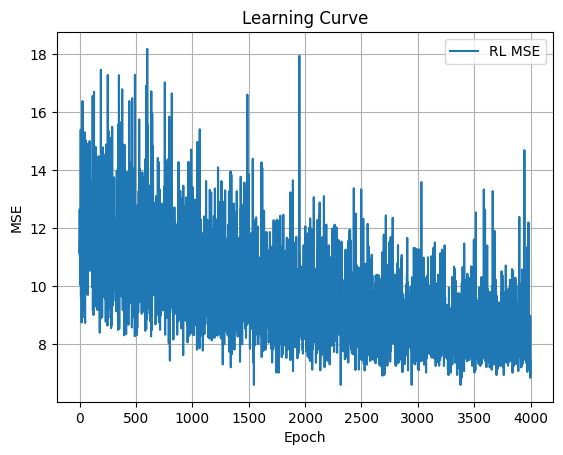

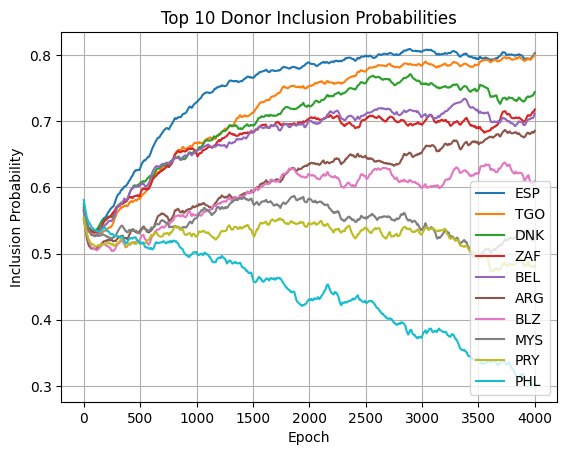

🔹 Benchmark MSE (AR(1)): 9.260189950189009
🔹 Benchmark MSE (Target only): 10.511369224125499
🔹 Benchmark MSE (Full panel): 11.453759086891456
🔹 Benchmark MSE (Best bundle): 7.47305787099482


In [14]:
rl.plot_learning_curve()
rl.plot_donor_probs(top_n=10)
rl.compute_benchmarks()

In [12]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, input_dim)
        self.linear.weight.data = torch.eye(input_dim)
        self.linear.bias.data.fill_(0)

    def forward(self, x):
        return self.linear(x)

policy_net = PolicyNet(input_dim=len(donor_isos))
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

In [13]:
def forecast_for_year(t, included_isos):
    df_train = df[df['year'] < t]
    train_rows = df_train[df_train['ISO3'] == target_iso]
    for iso in included_isos:
        train_rows = pd.concat([train_rows, df_train[df_train['ISO3'] == iso]])

    X_train = train_rows.drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_train = train_rows['rGDP_chg'].values

    model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
    model.fit(X_train, y_train)

    x_eval = df[(df['ISO3'] == target_iso) & (df['year'] == t)].drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_true = df[(df['ISO3'] == target_iso) & (df['year'] == t)]['rGDP_chg'].values[0]
    y_pred_val = model.predict(x_eval)[0]
    return (y_pred_val - y_true) ** 2

In [14]:
# Logging containers
top_bundles = []  # List of tuples: (avg_mse, bundle, epoch)
avg_mse_per_epoch = []
inclusion_probs_by_donor = {iso: [] for iso in donor_isos}
baseline = 0.0

# Training loop
for epoch in range(total_epochs):
    logits = policy_net(similarities.unsqueeze(0)).squeeze()
    probs = torch.sigmoid(logits)

    # === REPLAY BEST BUNDLES MECHANISM ===
    use_replay = False #np.random.rand() < 0.2 and len(top_bundles) > 0
    if use_replay:
        _, included_isos, _ = top_bundles[np.random.randint(len(top_bundles))]
        inclusion_tensor = torch.tensor([1.0 if iso in included_isos else 0.0 for iso in donor_isos], dtype=torch.float32)
    else:
        inclusion_tensor = torch.bernoulli(probs)
        included_isos = [donor_isos[i] for i in range(len(donor_isos)) if inclusion_tensor[i].item() == 1]

    if len(included_isos) == 0:
        continue

    total_loss = 0.0
    errors = Parallel(n_jobs=-1)(delayed(forecast_for_year)(t, included_isos) for t in forecast_years)
    total_loss = sum(errors)

    avg_mse = total_loss / len(forecast_years)

    # === Store best bundles ===
    bundle_info = (avg_mse, included_isos.copy(), epoch)
    top_bundles.append(bundle_info)
    top_bundles = sorted(top_bundles, key=lambda x: x[0])[:5]  # keep top 5 by lowest MSE

    # === Policy update ===
    reward = -avg_mse
    baseline = 0.95 * baseline + 0.05 * reward
    advantage = reward - baseline

    log_probs = torch.log(probs + 1e-8) * inclusion_tensor
    policy_loss = -log_probs.sum() * advantage
    policy_loss += 0.01 * inclusion_tensor.sum()  # mild L1 regularization

    entropy = -(probs * torch.log(probs + 1e-8) + (1 - probs) * torch.log(1 - probs + 1e-8)).sum()
    policy_loss -= 0.1 * entropy  # encourage exploration

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    # === Log current probabilities ===
    with torch.no_grad():
        final_probs = torch.sigmoid(policy_net(similarities.unsqueeze(0)).squeeze())
        for i, iso in enumerate(donor_isos):
            inclusion_probs_by_donor[iso].append(final_probs[i].item())

    avg_mse_per_epoch.append(avg_mse)

    # === Print status ===
    if epoch % 10 == 0:
        print(f"Epoch {epoch} — Avg MSE: {avg_mse:.4f}, Reward: {reward:.4f}, Advantage: {advantage:.4f}, Bundle Size: {int(inclusion_tensor.sum().item())}")

Epoch 0 — Avg MSE: 11.7316, Reward: -11.7316, Advantage: -11.1450, Bundle Size: 11
Epoch 10 — Avg MSE: 9.3913, Reward: -9.3913, Advantage: -4.6772, Bundle Size: 8
Epoch 20 — Avg MSE: 10.3183, Reward: -10.3183, Advantage: -3.1253, Bundle Size: 10
Epoch 30 — Avg MSE: 12.2370, Reward: -12.2370, Advantage: -2.8255, Bundle Size: 11
Epoch 40 — Avg MSE: 10.3172, Reward: -10.3172, Advantage: -0.1873, Bundle Size: 12
Epoch 50 — Avg MSE: 10.8366, Reward: -10.8366, Advantage: 0.1576, Bundle Size: 17
Epoch 60 — Avg MSE: 10.4214, Reward: -10.4214, Advantage: 1.0690, Bundle Size: 7
Epoch 70 — Avg MSE: 11.3247, Reward: -11.3247, Advantage: 0.4054, Bundle Size: 10
Epoch 80 — Avg MSE: 10.5180, Reward: -10.5180, Advantage: 1.1566, Bundle Size: 13
Epoch 90 — Avg MSE: 13.7208, Reward: -13.7208, Advantage: -2.2434, Bundle Size: 10
Epoch 100 — Avg MSE: 10.0524, Reward: -10.0524, Advantage: 1.1860, Bundle Size: 12
Epoch 110 — Avg MSE: 9.2669, Reward: -9.2669, Advantage: 1.9619, Bundle Size: 9
Epoch 120 — Avg

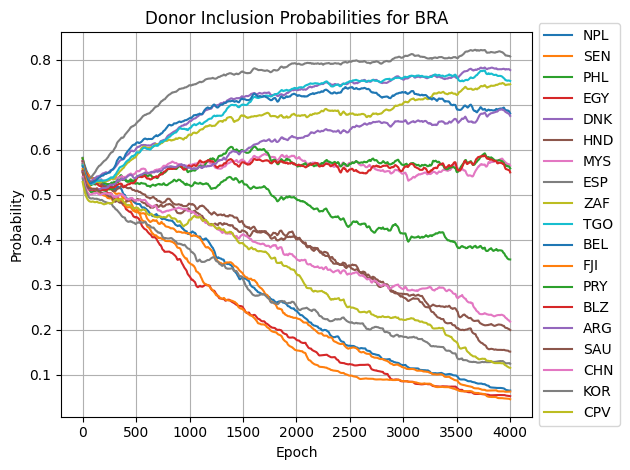

In [15]:
import matplotlib.pyplot as plt

for iso, probs in inclusion_probs_by_donor.items():
    plt.plot(probs, label=iso)
plt.title(f"Donor Inclusion Probabilities for {target_iso}")
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
final_probs = torch.sigmoid(policy_net(similarities.unsqueeze(0)).squeeze()).detach().numpy()
top_donors = sorted(zip(donor_isos, final_probs), key=lambda x: -x[1])[:10]
print(f"Top 10 similar countries to {target_iso}:")
for iso, score in zip(donor_isos[:10], similarity_scores[:10]):
    print(f"{iso}: {score:.4f}")   
print(f"Top donors for {target_iso}:")
for iso, prob in top_donors:
    print(f"{iso}: {prob:.4f}")

Top 10 similar countries to BRA:
NPL: 0.3378
SEN: 0.3331
PHL: 0.3323
EGY: 0.3083
DNK: 0.3055
HND: 0.3043
MYS: 0.2852
ESP: 0.2833
ZAF: 0.2697
TGO: 0.2693
Top donors for BRA:
ESP: 0.8073
DNK: 0.7771
TGO: 0.7530
ZAF: 0.7455
BEL: 0.6808
ARG: 0.6754
MYS: 0.5647
PRY: 0.5586
BLZ: 0.5499
PHL: 0.3563


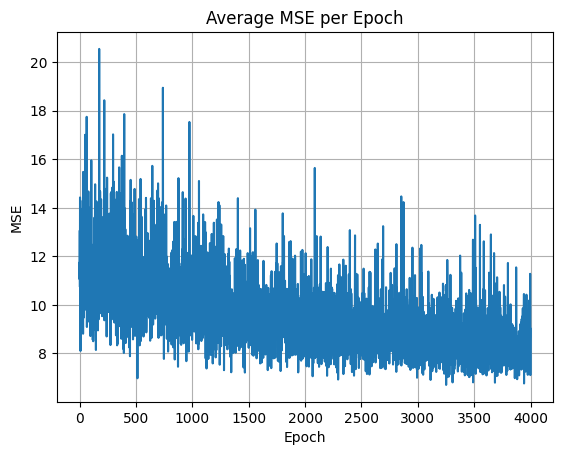

In [17]:
# plot avg_mse_per_epoch 
plt.plot(avg_mse_per_epoch)
plt.title("Average MSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [18]:
print("\nTop 5 Best Bundles by Avg MSE:")
for mse, bundle, ep in top_bundles:
    print(f"Epoch {ep} — MSE: {mse:.4f}, Bundle: {bundle}")


Top 5 Best Bundles by Avg MSE:
Epoch 3251 — MSE: 6.7055, Bundle: ['DNK', 'MYS', 'ESP', 'ZAF', 'TGO', 'BEL', 'BLZ', 'ARG', 'CHN']
Epoch 3942 — MSE: 6.7657, Bundle: ['DNK', 'ESP', 'ZAF', 'TGO', 'PRY', 'ARG']
Epoch 3684 — MSE: 6.7984, Bundle: ['DNK', 'MYS', 'ESP', 'BEL', 'ARG']
Epoch 3308 — MSE: 6.8089, Bundle: ['DNK', 'ESP', 'ZAF', 'BEL', 'BLZ', 'ARG']
Epoch 3490 — MSE: 6.8106, Bundle: ['DNK', 'MYS', 'ESP', 'ZAF', 'ARG']


In [19]:
from statsmodels.tsa.ar_model import AutoReg

# AR(1) benchmark: train on lagged GDP only
ar_loss = 0.0

# Get the full series of target country
target_df = df[df['ISO3'] == target_iso].sort_values('year')
target_years = target_df['year'].values
target_series = target_df['rGDP_chg'].values

# Loop over forecast years
for t in forecast_years:
    # Find index for the forecast year
    idx = np.where(target_years == t)[0]
    if len(idx) == 0 or idx[0] < 2:
        continue
    idx = idx[0]

    # Train AR(1) model up to year t-1
    y_train = target_series[:idx]
    ar_model = AutoReg(y_train, lags=1, old_names=False).fit()

    # Forecast for year t
    y_pred = ar_model.predict(start=idx, end=idx)[0]
    y_true = target_series[idx]
    
    ar_loss += (y_pred - y_true) ** 2

# Compute average AR(1) MSE
ar_mse = ar_loss / len(forecast_years)

# 1. Solo benchmark (target only)
solo_loss = 0.0
for t in forecast_years:
    df_train = df[(df['ISO3'] == target_iso) & (df['year'] < t)]
    X_train = df_train.drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_train = df_train['rGDP_chg'].values

    model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
    model.fit(X_train, y_train)

    x_eval = df[(df['ISO3'] == target_iso) & (df['year'] == t)].drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_true = df[(df['ISO3'] == target_iso) & (df['year'] == t)]['rGDP_chg'].values[0]
    y_pred = model.predict(x_eval)[0]

    solo_loss += (y_pred - y_true) ** 2

solo_mse = solo_loss / len(forecast_years)

# 2. Full panel benchmark (target + all donors)
full_loss = 0.0
for t in forecast_years:
    df_train = df[df['year'] < t]
    X_train = df_train.drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_train = df_train['rGDP_chg'].values

    model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
    model.fit(X_train, y_train)

    x_eval = df[(df['ISO3'] == target_iso) & (df['year'] == t)].drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_true = df[(df['ISO3'] == target_iso) & (df['year'] == t)]['rGDP_chg'].values[0]
    y_pred = model.predict(x_eval)[0]

    full_loss += (y_pred - y_true) ** 2

full_mse = full_loss / len(forecast_years)

# 3. "Optimal" panel benchmark (target + top donors)
opt_bundle = top_bundles[0][1]#[iso for iso, _ in top_donors[:10]]
opt_loss = 0.0
for t in forecast_years:
    df_train = df[(df['ISO3'].isin([target_iso] + opt_bundle)) & (df['year'] < t)]
    X_train = df_train.drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_train = df_train['rGDP_chg'].values

    model = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
    model.fit(X_train, y_train)

    x_eval = df[(df['ISO3'] == target_iso) & (df['year'] == t)].drop(columns=['ISO3', 'year', 'rGDP_chg']).values
    y_true = df[(df['ISO3'] == target_iso) & (df['year'] == t)]['rGDP_chg'].values[0]
    y_pred = model.predict(x_eval)[0]

    opt_loss += (y_pred - y_true) ** 2

opt_mse = opt_loss / len(forecast_years)

# Print benchmarks
print("--- Benchmark Results ---")
print(f"🔹 Benchmark MSE (AR(1)):       {ar_mse:.4f}")
print(f"🔹 Benchmark MSE (Target only): {solo_mse:.4f}")
print(f"🔹 Benchmark MSE (Full panel):  {full_mse:.4f}")
print(f"🔹 Benchmark MSE (Top donors):  {opt_mse:.4f}")

--- Benchmark Results ---
🔹 Benchmark MSE (AR(1)):       9.2602
🔹 Benchmark MSE (Target only): 10.5998
🔹 Benchmark MSE (Full panel):  11.0649
🔹 Benchmark MSE (Top donors):  7.1692
